In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import seaborn as sns

In [50]:
# Define a simple Multilayer Perceptron (MLP) model
#Simple feedforward ANN for decoding kinematics

class model_ann(nn.Module):
    def __init__(self, input_size, output_size, layer_size):
        super(model_ann, self).__init__()
        self.input_size,  self.layer_size, self.output_size = input_size, layer_size, output_size

        #List layer sizes
        self.layer_hidden = np.concatenate([[input_size], layer_size])

        # Initialize masking dict
        self.mask_list = None
        self.unit_lookup = None
        self.reset_mask()
        assert len(self.mask_list) == len(layer_size)

         
        #Compile layers into lists
        self.layer_list = nn.ModuleList(
            [nn.Linear(in_features=self.layer_hidden[idx], out_features=self.layer_hidden[idx+1]) for idx in range(len(self.layer_hidden)-1)])

        self.fc = nn.Linear(self.layer_size[-1], self.output_size)

    def update_mask(self, mask_units):
        self.reset_mask()
        for mask_unit in mask_units:
            unit_idx = self.unit_lookup[mask_unit]['unit']
            layer_idx = self.unit_lookup[mask_unit]['layer']

            self.mask_list[layer_idx][unit_idx] = False


    def reset_mask(self):
        # Lookup table for masked units
        self.mask_list = list()
        self.unit_lookup = dict()
        unit_count= 0
        for layer_idx in range(len(self.layer_size)):
            num_units = self.layer_size[layer_idx]
            mask_tensor = torch.tensor(np.repeat(True, num_units))
            self.mask_list.append(mask_tensor)
            for unit_idx in range(num_units):
                self.unit_lookup[unit_count] = {'layer': layer_idx, 'unit': unit_idx}
                unit_count += 1

 
    def forward(self, x):
        x = x.view(x.size(0), -1)
        #Encoding step
        x_list = list()
        for idx in range(len(self.layer_list)):
            x = torch.tanh(self.layer_list[idx](x))
            x_list.append(x)

            x.masked_fill(self.mask_list[idx], 0.0)
            # x[:, self.mask_list[idx]] = 0.0

        #Decoding step
        x = self.fc(x)

        return x, x_list


In [51]:
# Download and prepare the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

In [52]:
# Create data loaders for training and validation
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the MLP model and set up the loss function and optimizer
input_size = 28*28
output_size = 10
layer_size=[128, 64, 64, 64, 64, 64, 64, 64, 64]
model = model_ann(input_size, output_size, layer_size=layer_size)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [53]:

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")




KeyboardInterrupt: 

In [ ]:
# Validation
model.eval()
predicted_labels = list()
true_labels = list()
activations_list = list()

with torch.no_grad():
    for images, labels in test_loader:
        outputs, activations_batch = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.numpy())
        true_labels.extend(labels.numpy())
        activations_list.append(activations_batch)

true_labels = np.array(true_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 85.44%


In [ ]:
activations = np.concatenate([np.concatenate(act, axis=1) for act in activations_list], axis=0)
num_trials, num_neurons = activations.shape

# label_mask = true_labels == 5
# activations = activations[label_mask,:]


In [ ]:

trial_dists = list()
for neuron_idx in range(num_neurons):
    dists = pdist(activations[:500,neuron_idx].reshape(-1,1), 'euclidean')
    trial_dists.append(dists)
trial_dists = np.array(trial_dists)


In [ ]:
neuron_dists = squareform(pdist(trial_dists, 'correlation'))

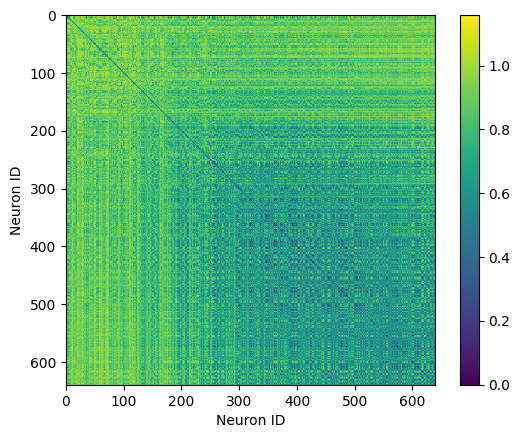

In [ ]:
plt.imshow(neuron_dists)
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')

plt.colorbar()

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, random_state=0, metric='precomputed', init='random')
points = tsne.fit_transform(neuron_dists)
kmeans_labels = KMeans(n_clusters=20, random_state=0).fit(points)

/home/ntolley/anaconda3/envs/torch_test/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
layer_ids = np.repeat(np.arange(len(layer_size)), layer_size)
df_dict = {'TSNE1': points[:,0], 'TSNE2': points[:,1], 'TSNE3': points[:,2],'layer': layer_ids, 'cluster': kmeans_labels.labels_}
df = pd.DataFrame(df_dict)

<Axes: xlabel='TSNE1', ylabel='TSNE2'>

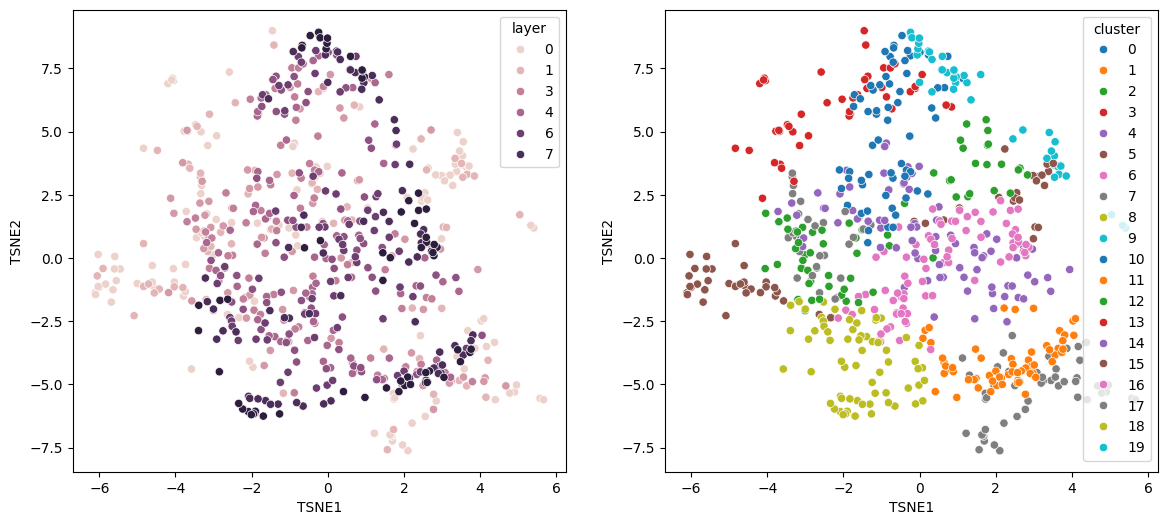

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='layer')

plt.subplot(1,2,2)
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='cluster', palette='tab10')

In [ ]:
# plt.figure(figsize=(20,20))
# sns.pairplot(df[['TSNE1', 'TSNE2', 'TSNE3', 'layer']], hue='layer',size=(20,20))

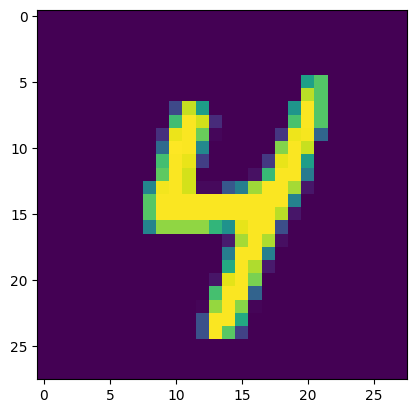

In [ ]:
plt.imshow(images[3,0,:,:])

In [ ]:
activations[2].size()

torch.Size([16, 64])